In [40]:
library(tidyverse)
library(limma)
library(data.table)
library(glue)
library(gridExtra)
library(patchwork)

In [41]:
pca_plot <- function(df, batch_info, title, 
                     path = "", 
                     quantitative_col_name = "Quantitative.column.name", 
                     col_col = "Group", 
                     shape_col = "Center",
                     show_legend = TRUE) {
  pca <- prcomp(t(na.omit(df)))
  pca_df <- pca$x %>%
    as.data.frame() %>%
    rownames_to_column(quantitative_col_name) %>% 
    left_join(batch_info, by = quantitative_col_name)
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  pca_plot <- pca_df %>%
    ggplot(aes_string(x = "PC1", y = "PC2", color = col_col, shape = shape_col)) + # Note: aes_string is deprecated, consider using aes() with !!sym() for newer versions
    geom_point(size=3) +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

  if(!show_legend){
    pca_plot <- pca_plot + 
      theme(legend.position = "none")
  }


  if (path == "") {
    return(pca_plot)
  } else {
    ggsave(path, pca_plot, width = 5, height = 5)
    return(pca_plot)
  }
}

# boxplot
boxplot_pg <- function(protein_matrix, metadata_df, quantitativeColumnName, color_col, title, path) {
  # Reshape data into long format
  long_data <- tidyr::gather(protein_matrix, 
                             key = "file", value = "Intensity")
  merged_data <- merge(long_data, metadata_df, by.x = "file", by.y = quantitativeColumnName)
  
  # Log tranformed scale
  boxplot <- ggplot(merged_data, aes(x = file, y = Intensity, fill = .data[[color_col]])) + 
    geom_boxplot() +
    stat_summary(fun = mean, geom = "point", shape = 4, size = 3, color = "red") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    # adjust fonsize for the x-axis
    theme(axis.text.x = element_text(size = 8)) +
    labs(title = title) 

  if(path == "") {
    return(boxplot)
  } else {
      ggsave(path, boxplot)
      return(boxplot)
  }
}

plotIntensityDensityByPool <- function(
    intensities_df, metadata_df, quantitativeColumnName, poolColumnName, title
) {
  # Reshape the intensities_df from wide to long format
  long_intensities <- reshape2::melt(intensities_df, 
    variable.name = "Sample", value.name = "Intensity")
  
  # Adjust the merge function based on your metadata column names
  merged_data <- merge(long_intensities, metadata_df, by.x = "Sample", by.y = quantitativeColumnName)
  
  # Plot the data
  ggplot(merged_data, aes(x = Intensity, color = .data[[poolColumnName]])) +  
    geom_density() +
    theme_minimal() +
    labs(title = paste(title, " by", poolColumnName),
         x = "Intensity",
         y = "Density")
}


In [42]:
# ffrom PRONE.R

medianNorm <- function(dt){
  # find median of each sample
  sample_med <- apply(dt, 2, stats::median, na.rm=TRUE) # columns
  # find mean of medians
  mean_med <- mean(sample_med, na.rm=TRUE)
  # divide data by median
  norm_dt <- t(t(dt)/sample_med)
  # multiply data by mean of medians
  norm_dt <- norm_dt * mean_med
  norm_dt <- data.table::as.data.table(norm_dt)
  colnames(norm_dt) <- colnames(dt)
  rownames(norm_dt) <- rownames(dt)
  return(norm_dt)
}

irsNorm <- function(dt, md, batch, refs){
  # get md of reference samples
  refs_md <- md[md$Quantitative.column.name %in% refs,]
# separate data by batch
  dt_list <- lapply(unique(md[["Pool"]]), function(b){
      md_chunk <- md[md[["Pool"]] == b,]
      dt_chunk <- subset(dt, select = md_chunk$Quantitative.column.name)
      return(dt_chunk)
  })
  names(dt_list) <- unique(md[["Pool"]])
  
  # take reference sample intensities
  irs <- subset(dt, select = refs_md$Quantitative.column.name)
  colnames(irs) <- as.character(refs_md[refs_md$Quantitative.column.name %in% refs,][["Pool"]])
  
  # get the geometric average intensity for each protein
  irs <- tibble::as_tibble(irs)
  irs$average <- apply(irs, 1, function(x) exp(mean(log(x), na.rm=TRUE)))
  # normalize data
  dt_irs_list <- lapply(names(dt_list), function(b){
    # compute scaling factor vectors
    fac <- irs$average / irs[,b]
    # normalize
    dt_irs_chunk <- dt_list[[b]] * fac[,1]
    return(dt_irs_chunk)
  })
  # reconstruct data after irs normalization
  dt_irs <- do.call(cbind, dt_irs_list)
  dt_irs <- data.table::as.data.table(dt_irs)
  dt_irs <- subset(dt_irs, select = colnames(dt))
  
  return(dt_irs)
}

In [43]:
library(ggrepel)

volcano_plot <- function(result, title, show_names=TRUE, show_legend=TRUE) {
  result$P.Value.log <- -log10(result$adj.P.Val)

  volcano_plot <- ggplot(result, aes(x = logFC, y = P.Value.log, color = abs(logFC) > 0.25 & P.Value.log > -log10(0.05))) +
    # add name to the color legeng
    scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black"), 
                        name = "DE proteins") +
    # add line for p-value threshold (0.05) and logFC threshold (1)
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
    geom_vline(xintercept = c(-0.25, 0.25), linetype = "dashed") +
    geom_point() +
    theme_minimal() +
    xlab("Log Fold Change") +
    ylab("-log10 P-value") +
    ggtitle(paste0("Volcano plot for limma results, ", title))

  # if show lgene is False, remove the legend
  if(show_legend == FALSE){
    volcano_plot <- volcano_plot + theme(legend.position = "none")
  }

  if(show_names == TRUE){
    # add names for PG that passed the thresholds -- using rownames as labels
    volcano_plot <- volcano_plot + 
      geom_text_repel(data = result[result$adj.P.Val < 0.05 & abs(result$logFC) > 0.25,], 
                    aes(label = rownames(result[result$adj.P.Val < 0.05 & abs(result$logFC) > 0.25,])), 
                    size = 3) 
  }
  return(volcano_plot)
}

# Load data - Genes from PG

In [44]:
title = "Genes from PG.txt"

In [45]:
path_to_data <- "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/01_PG_Genes/"
centers <- c("Center1", "Center2", "Center3")

############## Read intensities from all centers ##############
intensities <- lapply(centers, function(center) {
  read_tsv(file.path(path_to_data, paste0(center, "/genes_intensities.tsv")), show_col_types = FALSE)
})

# print number of rows in each data frame
print(paste("Number of rows in each data frame: ", sapply(intensities, nrow)))

# merge intensities using Gene.names column
intensities <- Reduce(function(x, y) {
  merge(x, y, by = "Gene.names")
}, intensities)
intensities <- intensities %>% mutate_all(~replace(., . == 0, NA)) %>%
  column_to_rownames("Gene.names")

print(paste("Number of rows in merged data frame: ", nrow(intensities)))

############## Read metadata from all centers ##############
metadata <- lapply(centers, function(center) {
  read_tsv(file.path(path_to_data, paste0(center, "/metadata.tsv")), 
    col_types = cols(.default = "c"), skip = 1,
    col_names = c("Raw.name", "Quantitative.column.name", "Pool", "Reporter.ion", "Patient", "Group", "Center"))
})
print(paste("Number of rows in each metadata data frame: ", sapply(metadata, nrow)))

# cbind metadata
metadata <- rbindlist(metadata)
print(paste("Number of rows in merged metadata data frame: ", nrow(metadata)))


############## Order column in intensities ##############
intensities <- intensities[,metadata$Quantitative.column.name]

[1] "Number of rows in each data frame:  473"
[2] "Number of rows in each data frame:  504"
[3] "Number of rows in each data frame:  432"
[1] "Number of rows in merged data frame:  356"


[1] "Number of rows in each metadata data frame:  22"
[2] "Number of rows in each metadata data frame:  21"
[3] "Number of rows in each metadata data frame:  22"
[1] "Number of rows in merged metadata data frame:  65"


In [46]:
head(metadata, 2)
head(intensities, 2)

Raw.name,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Reporter.intensity.corrected.1.Pool1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
Reporter.intensity.corrected.2.Pool1,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1


,P_1.RIC_1,P_1.RIC_2,P_1.RIC_3,P_1.RIC_4,P_1.RIC_5,P_1.RIC_6,P_1.RIC_7,P_1.RIC_8,P_1.RIC_9,P_1.RIC_10,⋯,P_6.RIC_2,P_6.RIC_3,P_6.RIC_4,P_6.RIC_5,P_6.RIC_6,P_6.RIC_7,P_6.RIC_8,P_6.RIC_9,P_6.RIC_10,P_6.RIC_11
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,821950,734770,837540,772860,603760,684800,750210,775530,676300,781010,⋯,16985000,15344000,17568000,15650000,16915000,14671000,16319000,16130000,18150000,15035000
A2M,2475200,2514400,2741200,1634700,3682000,1630300,1534500,1744800,2449700,2225900,⋯,15496000,15313000,26161000,13454000,13967000,42095000,12930000,54405000,22753000,16212000


#  Remove existing reference

In [47]:
# cat("Number of rows in metadata: ", nrow(metadata), "\n")
# metadata <- metadata %>% 
#     filter(Group != 'Common Reference')
# cat("Number of rows in metadata after filtering: ", nrow(metadata), "\n")

# cat("Number of samples in intensities: ", ncol(intensities), "\n")
# intensities <- intensities[,metadata$Quantitative.column.name]
# cat("Number of samples in intensities after filtering: ", ncol(intensities), "\n")

# Filtering

In [48]:
# keep only rows if there are at least two non-NA values in each Center
samples_center1 <- metadata[metadata$Center == "Center1",]$"Quantitative.column.name"
samples_center2 <- metadata[metadata$Center == "Center2",]$"Quantitative.column.name"
samples_center3 <- metadata[metadata$Center == "Center3",]$"Quantitative.column.name"

cat('Before filtering:', dim(intensities), '\n')
intensities <- intensities[rowSums(!is.na(intensities[, samples_center1])
    ) >= 2 & rowSums(!is.na(intensities[, samples_center2])
    ) >= 2 & rowSums(!is.na(intensities[, samples_center3])) >= 2 ,]
cat('After filtering:', dim(intensities))

Before filtering: 356 65 
After filtering: 352 65

In [49]:
# keep only rows if there are at least two non-NA values in each condition
samples_condition_A <- metadata[metadata$Group == "heathy",]$"Quantitative.column.name"
samples_condition_B <- metadata[metadata$Group == "FSGS",]$"Quantitative.column.name"

intensities <- intensities[rowSums(!is.na(intensities[, samples_condition_A])) >= 2 & rowSums(!is.na(intensities[, samples_condition_B])) >= 2,]
cat('After filtering:', dim(intensities))

After filtering: 352 65

No id variables; using all as measure variables



No id variables; using all as measure variables

Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_summary()`).”


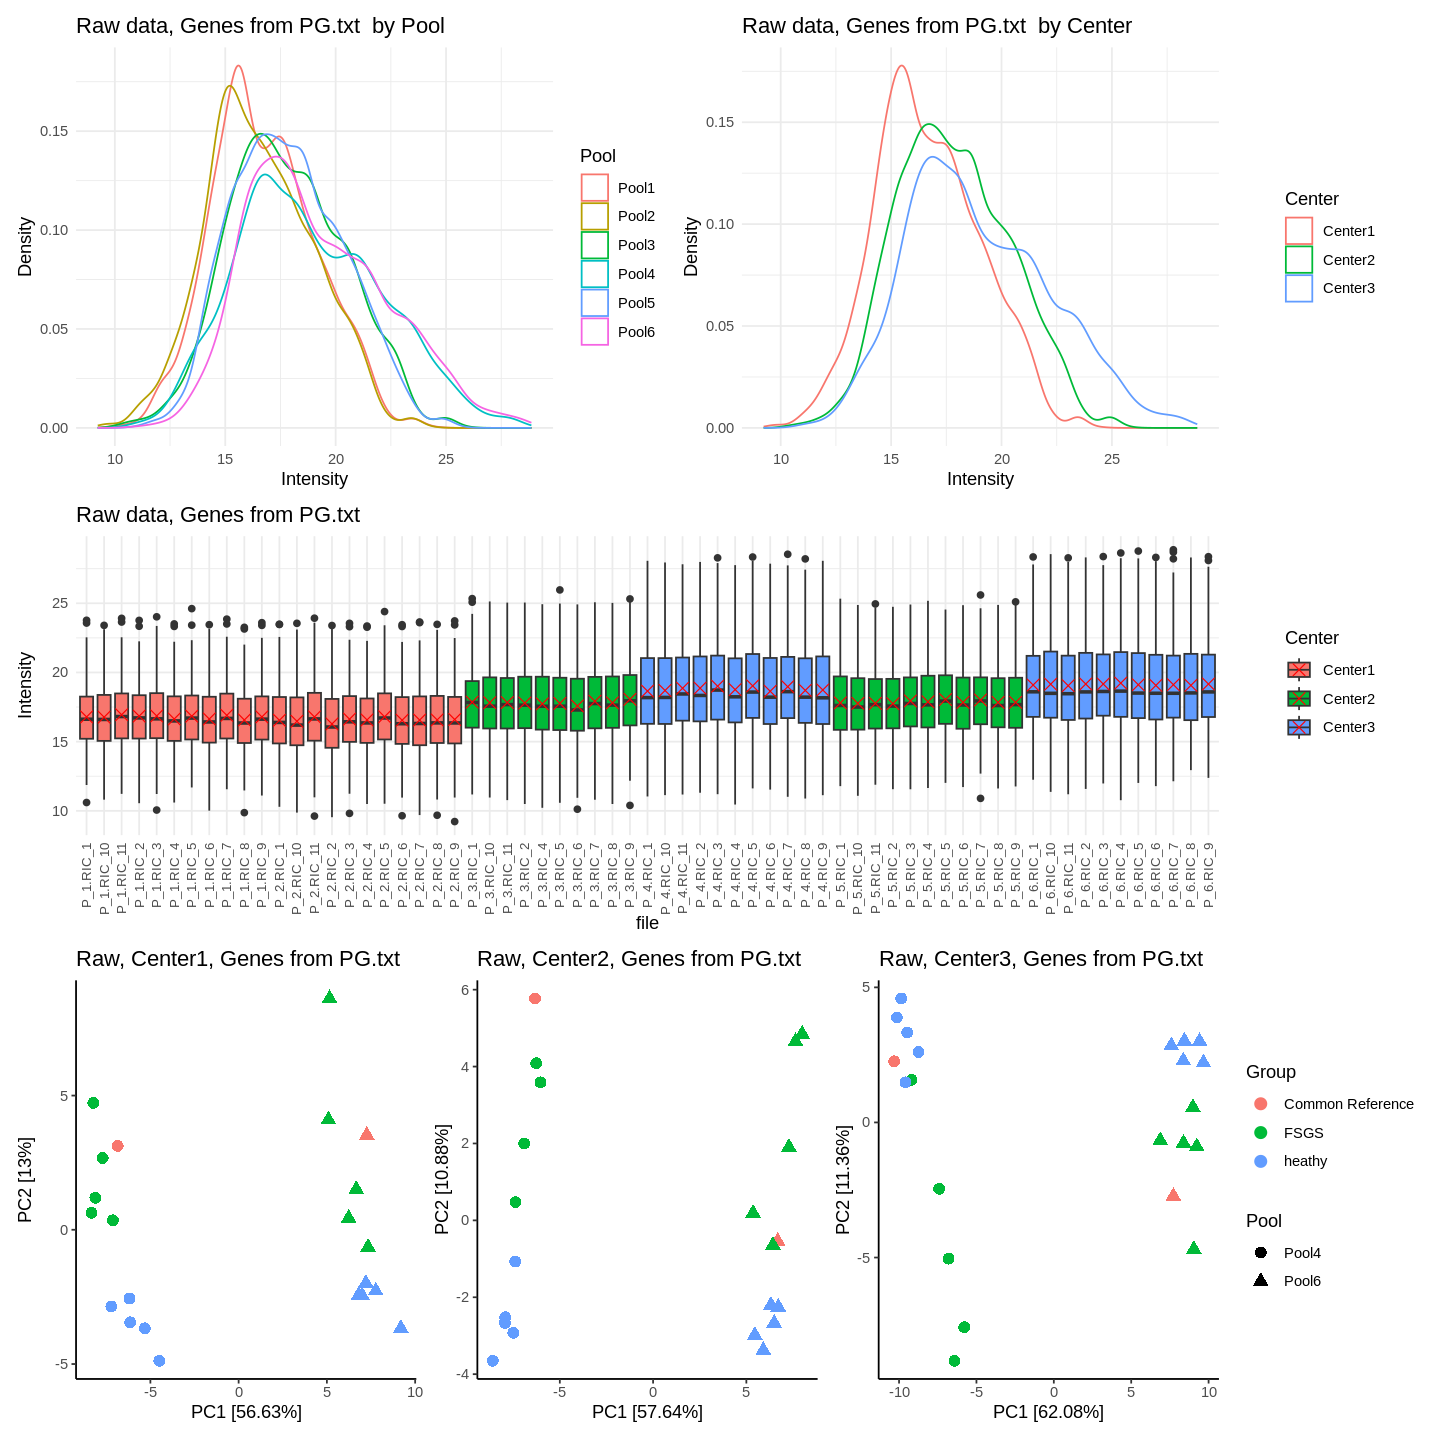

In [50]:
plot_density <- plotIntensityDensityByPool(log2(intensities+1), metadata, "Quantitative.column.name", "Pool", paste0("Raw data, ", title))
# plot_pca <- pca_plot(log2(intensities+1), metadata, paste0("Raw data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(log2(intensities+1), metadata, "Quantitative.column.name", "Center", paste0("Raw data, ", title), "")
plot_density_c <- plotIntensityDensityByPool(log2(intensities+1), metadata, "Quantitative.column.name", "Center", paste0("Raw data, ", title)) 


## pca for each center separately
pca_center1 <- pca_plot(log2(intensities[, samples_center1]+1), metadata[metadata$Center == "Center1",], paste0("Raw, Center1, ", title), shape_col = "Pool", show_legend = FALSE)
pca_center2 <- pca_plot(log2(intensities[, samples_center2]+1), metadata[metadata$Center == "Center2",], paste0("Raw, Center2, ", title), shape_col = "Pool", show_legend = FALSE)
pca_center3 <- pca_plot(log2(intensities[, samples_center3]+1), metadata[metadata$Center == "Center3",], paste0("Raw, Center3, ", title), shape_col = "Pool")


layout <- (plot_density + plot_density_c) /
          (plot_boxplot) /
          (pca_center1 + pca_center2 + pca_center3)
layout <- layout + plot_layout(heights = c(4, 3, 4))
options(repr.plot.width=12, repr.plot.height=12)
print(layout)

# Median normalization

In [51]:
medianNorm_intensities <- medianNorm(intensities) %>% as.data.frame()
rownames(medianNorm_intensities) <- rownames(intensities)

No id variables; using all as measure variables



No id variables; using all as measure variables

Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 415 rows containing non-finite values (`stat_summary()`).”


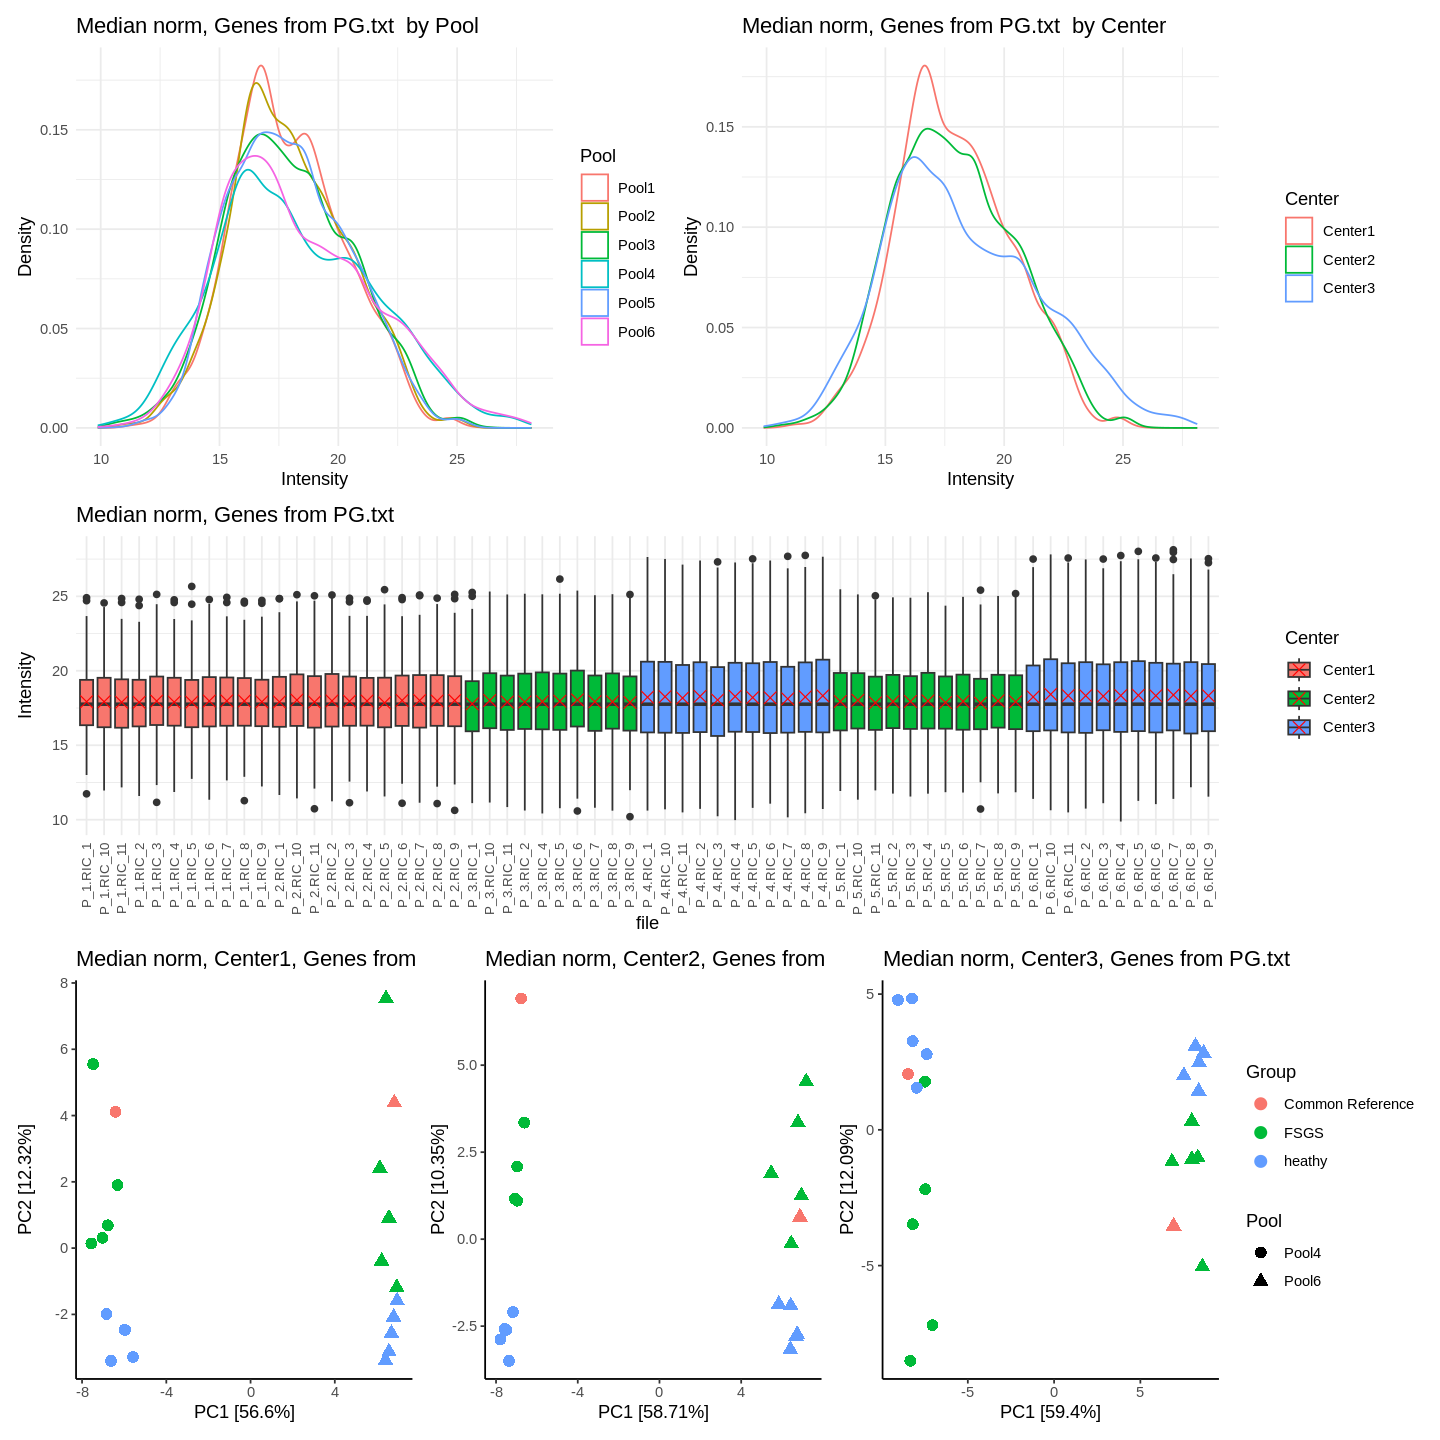

In [52]:
plot_density <- plotIntensityDensityByPool(log2(medianNorm_intensities+1), metadata, "Quantitative.column.name", "Pool", paste0("Median norm, ", title))
plot_pca <- pca_plot(log2(medianNorm_intensities+1), metadata, paste0("Median norm, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(log2(medianNorm_intensities+1), metadata, "Quantitative.column.name", "Center", paste0("Median norm, ", title), "")
plot_density_c <- plotIntensityDensityByPool(log2(medianNorm_intensities+1), metadata, "Quantitative.column.name", "Center", paste0("Median norm, ", title))

## pca for each center separately
pca_center1 <- pca_plot(log2(medianNorm_intensities[, samples_center1]+1), metadata[metadata$Center == "Center1",], paste0("Median norm, Center1, ", title), shape_col = "Pool", show_legend = FALSE)
pca_center2 <- pca_plot(log2(medianNorm_intensities[, samples_center2]+1), metadata[metadata$Center == "Center2",], paste0("Median norm, Center2, ", title), shape_col = "Pool", show_legend = FALSE)
pca_center3 <- pca_plot(log2(medianNorm_intensities[, samples_center3]+1), metadata[metadata$Center == "Center3",], paste0("Median norm, Center3, ", title), shape_col = "Pool")



layout <- (plot_density + plot_density_c) /
          (plot_boxplot) /
          (pca_center1 + pca_center2 + pca_center3)
layout <- layout + plot_layout(heights = c(4, 3, 4))
options(repr.plot.width=12, repr.plot.height=12)
print(layout)

# Create in silico refs and do iRs using them

We can perform the IRS method by creating a "mock" reference channel. For each TMT experiment, we will compute the reporter ion average over the 6 time points for each protein. For each protein, we will have 3 reference intensities, one from each TMT. We can compute the average reference intensity and compute 3 factors to adjust the reference value in each TMT experiment to the average. We will multiply that value for each TMT experiment times each of the 6 reporter ion channels for that TMT experiment.

https://pwilmart.github.io/IRS_normalization/understanding_IRS.html


In [53]:
# from https://pwilmart.github.io/IRS_normalization/understanding_IRS.html

get_samples <- function(data, center, pool, column_name = "Quantitative.column.name", with_cr = TRUE) {
  filtered_data <- data[data$Center == center & data$Pool == pool, ]
  return(filtered_data[[column_name]])
}

get_intensities <- function(intensities, data, center, pool, with_cr = TRUE) {
  samples <- get_samples(data, center, pool, with_cr=with_cr)
  return(intensities[, samples])
}

sum_rows <- function(data) {
  return(rowSums(data, na.rm = TRUE))
}

average_rows <- function(data) {
  return(rowMeans(data, na.rm = TRUE))
}

centers_and_pools <- list(
    c("Center1", "Pool1"),
    c("Center1", "Pool2"),
    c("Center2", "Pool3"),
    c("Center2", "Pool5"),
    c("Center3", "Pool4"),
    c("Center3", "Pool6")
)

irs <- tibble()

for(center_pool in centers_and_pools) {
  intensities_center_pool <- get_intensities(medianNorm_intensities, metadata, center_pool[[1]], center_pool[[2]])
  # print how many rows in intensities_center_pool haw all NA values
  cat(paste("Number of rows with all NA values in ", center_pool[[1]], center_pool[[2]], ": ", 
      sum(apply(intensities_center_pool, 1, function(x) all(is.na(x)))), "\n"))
  
  sum_center_pool <- average_rows(intensities_center_pool)
  
  new_col_name <- paste(center_pool[[1]], center_pool[[2]], sep="_")
  new_col_tibble <- tibble(!!new_col_name := sum_center_pool)


  if(nrow(irs) == 0) {
    irs <- new_col_tibble
  } else {
    irs <- bind_cols(irs, new_col_tibble)
  }
}

# add irs to median intensities 
medianNorm_intensities <- cbind(irs, medianNorm_intensities)
# add info about irs colnames to metadata as new rows
# Pool is the second part of colnames, Center is the first part
metadata <- rbind(metadata, 
  data.frame(
    Raw.name = colnames(irs), Quantitative.column.name = colnames(irs), 
    Pool = sapply(strsplit(colnames(irs), "_"), "[[", 2), 
    Center = sapply(strsplit(colnames(irs), "_"), "[[", 1),
    Reporter.ion = NA, Patient = NA, 
    Group = 'in silico'
    )
  )

irs$average <- apply(irs, 1, function(x) {
  non_zero_values <- x[x > 0]  # Exclude zeros from the computation
  non_zero_values <- non_zero_values[!is.na(non_zero_values)]
  exp(mean(log(non_zero_values)))  # Compute geometric mean of non-zero values
})

corrected_data <- list()

for(center_pool in centers_and_pools) {
  colname <- paste(center_pool[[1]], center_pool[[2]], sep="_")
  scaling_factor <- irs$average / irs[[colname]]
  intensities_center_pool <- get_intensities(medianNorm_intensities, metadata, center_pool[[1]], center_pool[[2]])
  intensities_corrected <- intensities_center_pool * scaling_factor
  corrected_data[[colname]] <- intensities_corrected
}

corrected_data <- bind_cols(corrected_data)
corrected_data <- corrected_data[, metadata$Quantitative.column.name]


cat('Before IRS normalization:', dim(medianNorm_intensities), "\n")
cat('After IRS normalization:', dim(corrected_data), "\n")


Number of rows with all NA values in  Center1 Pool1 :  3 
Number of rows with all NA values in  Center1 Pool2 :  5 
Number of rows with all NA values in  Center2 Pool3 :  7 
Number of rows with all NA values in  Center2 Pool5 :  2 
Number of rows with all NA values in  Center3 Pool4 :  14 
Number of rows with all NA values in  Center3 Pool6 :  6 
Before IRS normalization: 352 71 
After IRS normalization: 352 71 


In [54]:
# chack how many NAs are in the data
cat('Number of NAs in the data before IRS normalization:', sum(is.na(medianNorm_intensities)), "\n")
cat('Number of NAs in the data after IRS normalization:', sum(is.na(corrected_data)), "\n")
# replace 0 with NA
corrected_data <- corrected_data %>% mutate_all(~replace(., . == 0, NA)) 
cat('Number of NAs in the data after IRS normalization and replacing 0 with NA:', sum(is.na(corrected_data)), "\n")

Number of NAs in the data before IRS normalization: 452 
Number of NAs in the data after IRS normalization: 452 
Number of NAs in the data after IRS normalization and replacing 0 with NA: 452 


No id variables; using all as measure variables



Warning message:
“Removed 452 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 452 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 452 rows containing non-finite values (`stat_summary()`).”


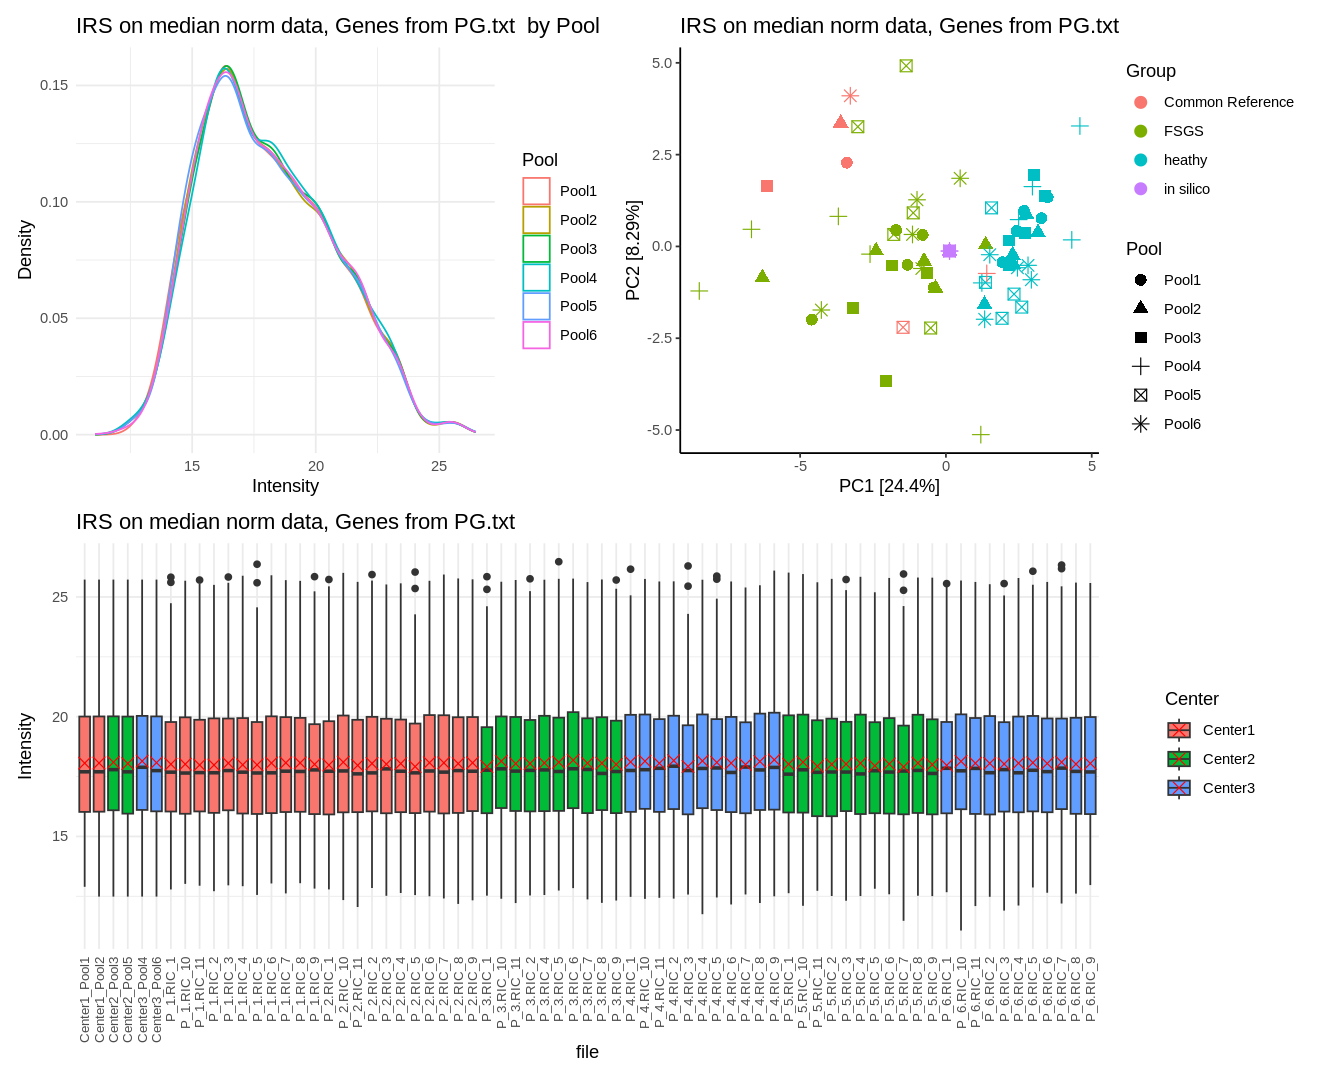

In [55]:
plot_density <- plotIntensityDensityByPool(log2(corrected_data+1), metadata, "Quantitative.column.name", "Pool", paste0("IRS on median norm data, ", title))
plot_pca <- pca_plot(log2(corrected_data+1), metadata, paste0("IRS on median norm data, ", title), shape_col = "Pool")
plot_boxplot <- boxplot_pg(log2(corrected_data+1), metadata, "Quantitative.column.name", "Center", paste0("IRS on median norm data, ", title), "")


layout <- (plot_density | plot_pca) /
          (plot_boxplot)

options(repr.plot.width=11, repr.plot.height=9)
print(layout)